Dorado Code for Inserting and Tracking Particles and Estimating Particle and Water Fluxes at a Specific (x,y,t)

In [19]:
# Install and import
!pip install pydorado  # install the particle routing package
!pip install matplotlib pillow
!pip install pickle-mixin
!pip install xarray

# libraries for loading our data
import pickle  # to access 'pickled' compressed data
import xarray as xr  # to load 'dimensional' data stored in netCDF files

# standard libraries for arrays and plots
import numpy as np  # base array manipulation library
import matplotlib.pyplot as plt  # standard plotting library

# library for particle simulation
import dorado
import pandas as pd 
from PIL import Image
import os
from PIL import Image

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [20]:
import warnings
warnings.filterwarnings('error', category=DeprecationWarning)

{'qx': <class 'netCDF4._netCDF4.Variable'>
float32 qx(time, y, x)
    units: cubic meters per second per meter
unlimited dimensions: 
current shape = (1560, 158, 223)
filling on, default _FillValue of 9.969209968386869e+36 used, 'qy': <class 'netCDF4._netCDF4.Variable'>
float32 qy(time, y, x)
    units: cubic meters per second per meter
unlimited dimensions: 
current shape = (1560, 158, 223)
filling on, default _FillValue of 9.969209968386869e+36 used, 'depth': <class 'netCDF4._netCDF4.Variable'>
float32 depth(time, y, x)
    units: meters
unlimited dimensions: 
current shape = (1560, 158, 223)
filling on, default _FillValue of 9.969209968386869e+36 used, 'stage': <class 'netCDF4._netCDF4.Variable'>
float32 stage(time, y, x)
    units: meters
unlimited dimensions: 
current shape = (1560, 158, 223)
filling on, default _FillValue of 9.969209968386869e+36 used}


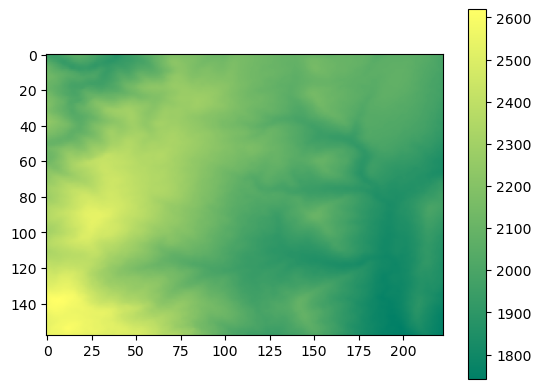

In [23]:
# Get data file
from netCDF4 import Dataset
fnm = 'hydrodynamic_results.nc'
file_id = Dataset(fnm)
print(file_id.variables)
stage = np.array(file_id.variables['stage'])
qx = np.array((file_id.variables['qx']))
thresholded_qx = qx
#np.where(qx < 2.0, 0, qx)
qy = np.array((file_id.variables['qy']))
thresholded_qy = qy
#np.where(qy < 2.0, 0, qy)

depth = file_id.variables['depth']
im = plt.imshow(stage[1,:,:], cmap='summer')
plt.colorbar(im)
plt.show()

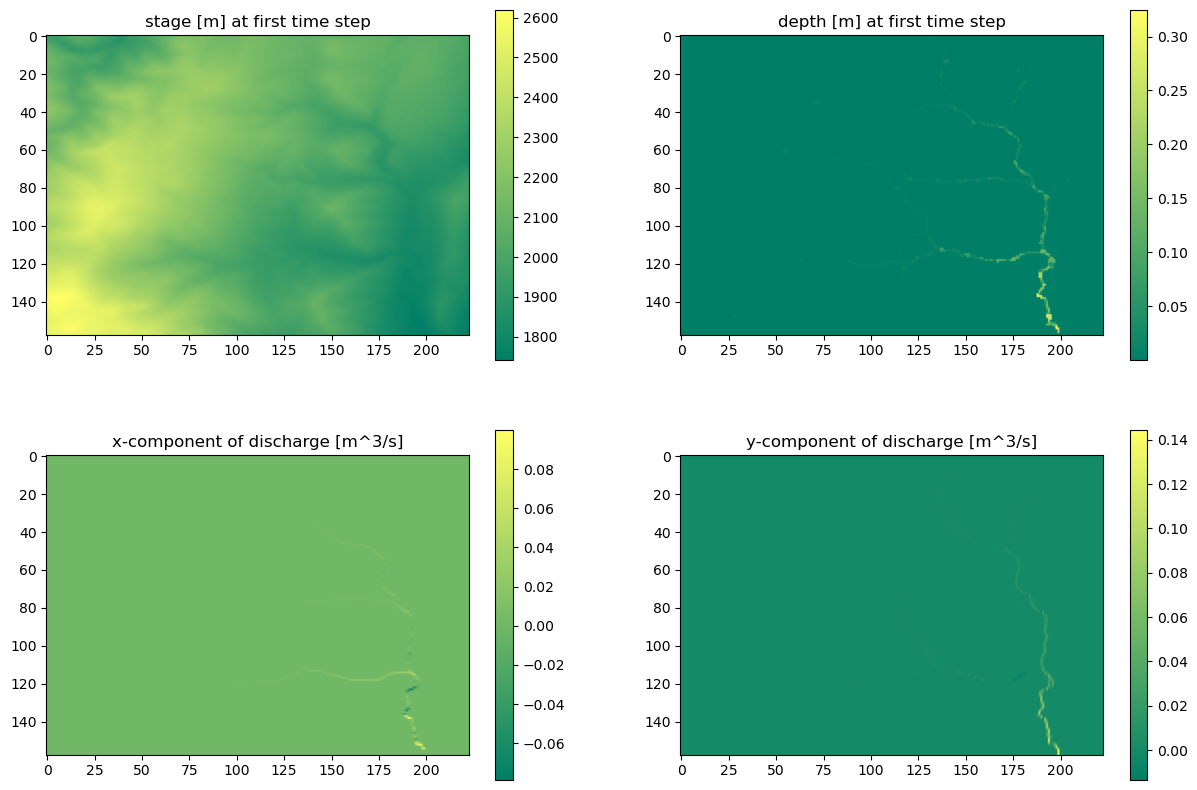

In [28]:
# ## Make a bunch of plots
t_oi = 1500
fig, ax = plt.subplots(2, 2, figsize=(15, 10))  # sets up a 2x2 set of axes

c1 = ax[0, 0].imshow(stage[t_oi,:,:],cmap='summer')  # shows the stage grid
ax[0, 0].set_title('stage [m] at first time step')  # title for stage grid
fig.colorbar(c1, ax=ax[0, 0])

c2 = ax[0, 1].imshow(depth[t_oi,:,:],cmap='summer')  # shows the depth grid
ax[0, 1].set_title('depth [m] at first time step')  # title for depth grid
fig.colorbar(c2, ax=ax[0, 1])

c3 = ax[1, 0].imshow(thresholded_qx[t_oi,:,:],cmap='summer')  # plots variable qx
ax[1, 0].set_title('x-component of discharge [m^3/s]')  # title
fig.colorbar(c3, ax=ax[1, 0])
             
c4 = ax[1, 1].imshow(thresholded_qy[t_oi,:,:],cmap='summer')  # plots variable qy
ax[1, 1].set_title('y-component of discharge [m^3/s]')  # title
fig.colorbar(c4, ax=ax[1, 1])

plt.show()  # displays the plot

In [ ]:
# plot the water depth and a line that we will investigate
# plt.figure(figsize=(10, 10))  # draw a bigger figure
# plt.imshow(onioncreek['depth'])  # plot depth
# plt.colorbar(shrink=0.4)  # add colorbar
# plt.plot(np.ones((50,))*150, np.linspace(125, 175), c='r')  # red line to look at in more detail
# plt.show()

In [29]:
# Load Params
# for any particle simulation, we start by defining model parameters
params = dorado.particle_track.modelParams()

# set the grid resolution
params.dx = 1005.84
params.dy = 1760.13

num_time_steps = len(depth)
time_steps = 120 #secobds
print(num_time_steps*120/60/60)

# provide information about the flow field
params.depth = depth[t_oi,:,:]
params.stage = stage[t_oi,:,:]
params.qx = thresholded_qx[t_oi,:,:]
params.qy = thresholded_qy[t_oi,:,:]

# finally we tell the model what hydrodynamic model we are using
params.model = 'ANUGA'

52.0


In [37]:
# Generate particles
# next we generate the particles themselves
particles = dorado.particle_track.Particles(params)  # supply model parameters

# decide where to first place particles and how many
seed_xloc = np.arange(80,100)
seed_yloc = [190]
# seed_xloc = list(range(120,140))
# seed_yloc = list(range(150,190))
                 
Np_tracer = 10  # 50 particles

# generate particles
particles.generate_particles(Np_tracer, seed_xloc, seed_yloc)

Theta parameter not specified - using 1.0
Gamma parameter not specified - using 0.05
Diffusion coefficient not specified - using 0.2
minimum depth for wetness not defined - using 10 cm
Cell Types not specified - Estimating from depth
Using weighted random walk


In [38]:
# now route the particles for a set time (in seconds)
#tt = 2*60*60  # 10 hours in seconds
# non steady flow field
tt = 10*60*60
walk_data = particles.run_iteration(target_time=tt)

<Axes: >

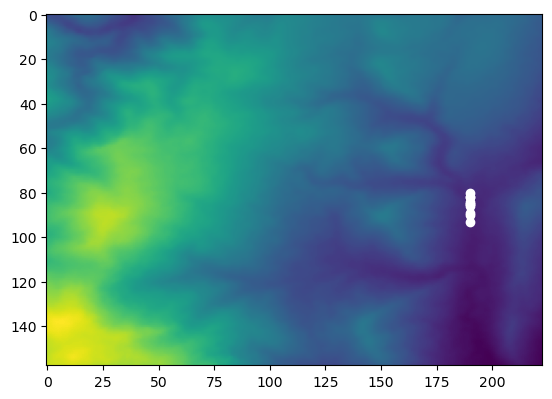

In [39]:
 dorado.routines.plot_state(stage[t_oi,:,:], walk_data, iteration=0, c='w')

In [47]:
plt.rcParams.update(

frames = []
t_step = 10*60
# from IPython.display import clear_output
fifteen = 10*60
frames_dir = 'frames'
for i in range(0, tt+t_step, t_step):
  dorado.routines.plot_state(
      stage[t_oi,:,:], walk_data, target_time=i, c='r')
  plt.title(str(i/60/60) + ' hours')
  frame_filename = f'frame_{i:03d}.png'
  plt.savefig(frame_filename)
  plt.close()
  frames.append(Image.open(frame_filename))
  # wd = walk_data
  # DF = pd.DataFrame(wd) 
  # fnm = "walkdata_" + str(i) + ".csv"
  # DF.to_csv(fnm)

TypeError: plot_state() got an unexpected keyword argument 's'

In [46]:
gif_filename = 'animation.gif'
frames[0].save(gif_filename, save_all=True, append_images=frames[1:], duration=101, loop=0)